<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/decision_tree/01_show_ways_modify_importance_features_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [291]:
import warnings
from unicodedata import normalize

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import (DecisionTreeRegressor, plot_tree)
from sklearn.compose import ColumnTransformer

# **Datos**
Conjunto de los volúmenes de gas suministrado por las Estaciones de Servicio en Colombia.

**Información de la Entidad**

- Área o dependencia: Dirección de Hidrocarburos
- Nombre de la Entidad: Ministerio de Minas y Energía
- Departamento: Bogotá D.C.
- Municipio: Bogotá D.C.
- Orden: Nacional
- Sector: Minas y Energía

**Información de Datos**

- Cobertura Geográfica: Nacional
- Frecuencia de Actualización: Diaria
- Fecha Emisión (aaaa-mm-dd): 2023-08-17
Suministró los datos: Ministerio de Minas y Energía

path data: https://www.datos.gov.co/Minas-y-Energ-a/Consulta-Ventas-de-Gas-Natural-Comprimido-Vehicula/v8jr-kywh/about_data

- **FECHA_VENTA**: fecha de la transacción
- **ANIO_VENTA**: fecha de la transacción
- **MES_VENTA**: fecha de la transacción
- **DIA_VENTA**: fecha de la transacción
- **CODIGO_MUNICIPIO_DANE**: Código del municipio
- **DEPARTAMENTO**: departamento
- **MUNICIPIO**: municipio
- **LATITUD**: coordenadas de georeferenciación
- **LONGITUD**: coordenadas de georeferenciación
- **TIPO_AGENTE**: tipo del agente proveedor
- **TIPO_DE_COMBUSTIBLE**: combustible suministrado
- **EDS_ACTIVAS**: estaciones de servicio activas
- **NUMERO_DE_VENTAS**: cantidad de tanqueadas en la eds
- **VEHICULOS_ATENDIDOS**: vehículos atendidos
-**CANTIDAD_VOLUMEN_SUMINISTRADO**: volumen suministrado en las tanqueadas

# **Propositos**
---

- Para la presente prueba de concepto se evaluará diferentes opciones para alterar la importancia de las características para un modelo de árboles de decisión.

#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

# **Funciones**
---

In [292]:
def normalize_word(word):
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns


def tree_plot(model, X_columns, y_columns):
  fig, ax = plt.subplots(figsize=(12, 5))
  print(f"Profundidad del árbol: {model.get_depth()}")
  print(f"Número de nodos terminales: {model.get_n_leaves()}")

  plot = plot_tree(
    decision_tree = model,
    feature_names = X_columns,
    class_names   = y_columns,
    filled        = True,
    impurity      = False,
    fontsize      = 5,
    precision     = 2,
    ax            = ax
)

def importances_feature(model, X_columns):
  """important predictors table"""
  importancia_predictores = pd.DataFrame(
      {'predictor': X_columns,
      'importancia': model.feature_importances_}
      )

  return importancia_predictores.sort_values('importancia', ascending=False)

# **Config**
---

In [293]:
random_seed = 12354
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Valor Contraprestaciones'
paleta = sns.color_palette('Set2').as_hex()
np.set_printoptions(precision=3, suppress=True)

# **Data**
---

In [294]:
url_materiales_mineros = 'https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'
url_materiales_mineros = 'https://drive.google.com/uc?id=' + url_materiales_mineros.split('/')[-2]
data_materiales_mineros = pd.read_csv(url_materiales_mineros, dtype='str')

In [295]:
# Normalización de los nombres de las columnas
data_materiales_mineros.columns = normalize_name_columns(
    data_materiales_mineros.columns)

In [296]:
data_materiales_mineros.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

In [297]:
# Se asigna los tipos de datos reales a los datos
data_materiales_mineros[[
    'valor_contraprestacion',
    'cantidad_produccion'
]] = data_materiales_mineros[[
    'valor_contraprestacion',
    'cantidad_produccion'
]].astype('float64')

In [298]:
# Se transforma una columna trimestre de texto a número
data_materiales_mineros[
    'trimestre'] = data_materiales_mineros[
        'trimestre'].apply(lambda x: x.split(' ')[1])

data_materiales_mineros.head(3)

,municipio_productor,departamento,recurso_natural,nombre_del_proyecto,ano_produccion,trimestre,unidad_medida,tipo_contraprestacion,valor_contraprestacion,cantidad_produccion
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,4,TONELADAS,REGALIAS,"614,258.00",0.00
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,4,TONELADAS,REGALIAS,"2,036,781.00","14,381.00"
2,Medellin,Antioquia,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,1,TONELADAS,REGALIAS,"836,927.00","16,308.00"


In [299]:
data_materiales_mineros[[
    'trimestre',
    'ano_produccion'
]] = data_materiales_mineros[[
    'trimestre',
    'ano_produccion'
]].astype('int32')

In [300]:
# Se tomará como periodo de datos para el entrenamiento de modelos 5 años
data_materiales_mineros = data_materiales_mineros[
    (data_materiales_mineros["ano_produccion"] >= 2018)
    &
    (data_materiales_mineros["ano_produccion"] < 2023)
    ]


In [301]:
data_materiales_mineros['key'] = data_materiales_mineros.municipio_productor.str.cat(
    data_materiales_mineros.departamento, sep='-')

In [302]:
# Movimiento Transacciones
function_dictionary = {
    "valor_contraprestacion": ['sum', 'count']
}

filter_feature = [
    'key',
    'ano_produccion',
    'trimestre',
    'tipo_contraprestacion']

new_val_col = [
    'valor_contraprestacion',
    'conteo_transacciones'
]


data_group = data_materiales_mineros.groupby(
    filter_feature).aggregate(function_dictionary)

data_group.columns = new_val_col
data_group = data_group.reset_index()

data_group.head()

,key,ano_produccion,trimestre,tipo_contraprestacion,valor_contraprestacion,conteo_transacciones
0,Abejorral-Antioquia,2018,1,REGALIAS,"2,783,489.00",1
1,Abejorral-Antioquia,2018,2,REGALIAS,"3,659,452.00",1
2,Abejorral-Antioquia,2018,3,REGALIAS,"5,732,763.00",1
3,Abejorral-Antioquia,2018,4,REGALIAS,"11,706,438.00",2
4,Abejorral-Antioquia,2019,1,REGALIAS,"5,793,131.00",2


In [303]:
# Movimiento Transacciones
function_dictionary = {
    "valor_contraprestacion": ['sum'],
    "conteo_transacciones": ['sum'],
    'trimestre': ['count'],
    'ano_produccion': ['nunique']
}

filter_feature = [
    'key',
    'tipo_contraprestacion']



data_group2 = data_group.groupby(
    filter_feature).aggregate(function_dictionary)

new_val_col = [
    'valor_contraprestacion',
    'numero_transacciones',
    'numero_trimestres_activos',
    'ano_produccion_activos',
]


data_group2.columns = new_val_col
data_group2 = data_group2.reset_index()

data_group2.head()

,key,tipo_contraprestacion,valor_contraprestacion,numero_transacciones,numero_trimestres_activos,ano_produccion_activos
0,Abejorral-Antioquia,REGALIAS,"52,580,674.00",17,11,4
1,Abrego-Norte de Santander,REGALIAS,"22,530,021.00",21,16,5
2,Abriaqui-Antioquia,REGALIAS,"355,266,722.00",35,15,5
3,Acacias-Meta,REGALIAS,"607,849,192.00",58,20,5
4,Achi-Bolivar,REGALIAS,"557,468,046.00",6,3,1


# **Split**
---

In [304]:
data_numerica = data_group2.select_dtypes(include=['float64', 'int64']).columns.to_list()
data_categorica = data_group2.select_dtypes(include=['object']).columns.to_list()

In [305]:
X = data_group2[data_numerica[1:]+data_categorica[1:]]
y = data_group2[data_numerica[1]]

In [306]:
compose_column = ColumnTransformer(
    [(
        'OneHot', OneHotEncoder(), data_categorica[1:]
    )],
    remainder='passthrough'
)

In [307]:
X_compose = compose_column.fit_transform(X)

In [308]:
encoded_cat = compose_column.named_transformers_['OneHot'].get_feature_names_out(data_categorica[1:]).tolist()
col = encoded_cat + data_numerica[1:]
col

['tipo_contraprestacion_COMPENSACIÓN',
 'tipo_contraprestacion_REGALIAS',
 'numero_transacciones',
 'numero_trimestres_activos',
 'ano_produccion_activos']

In [309]:
X =pd.DataFrame(X_compose, columns = col)

# **Model**
---

- Se tomara como base un modelo con una produndida de 3

In [310]:
model_base = DecisionTreeRegressor(
    max_depth = 3,
    random_state = random_seed,
)
params_base_master =  model_base.get_params()
model_base.fit(X, y)
importances_feature(model_base, X.columns)

,predictor,importancia
2,numero_transacciones,1.00
0,tipo_contraprestacion_COMPENSACIÓN,0.00
1,tipo_contraprestacion_REGALIAS,0.00
3,numero_trimestres_activos,0.00
4,ano_produccion_activos,0.00


- El preprocesamiento del presente conjunto de datos, tiene la peculiaridad de tener una sola característica importante, que el resto que no tiene efecto sobre la división del árbol.

- Una posible causa, puede ser por la poca variacion de las otras variables en comparación con la mas importante  (numero_transacciones)

In [311]:
print(f"""
- numero_transacciones: {X.numero_transacciones.var()}
- numero_trimestres_activos: {X.numero_trimestres_activos.var()}
- ano_produccion_activos: {X.ano_produccion_activos.var()}
- tipo_contraprestacion_COMPENSACIÓN: {X.tipo_contraprestacion_COMPENSACIÓN.var()}
- tipo_contraprestacion_REGALIAS: {X.tipo_contraprestacion_REGALIAS.var()}
""")


- numero_transacciones: 780.0220059277424
- numero_trimestres_activos: 44.45236583675853
- ano_produccion_activos: 1.8555611584129326
- tipo_contraprestacion_COMPENSACIÓN: 0.047382034659517576
- tipo_contraprestacion_REGALIAS: 0.04738203465951758



Profundidad del árbol: 3
Número de nodos terminales: 8


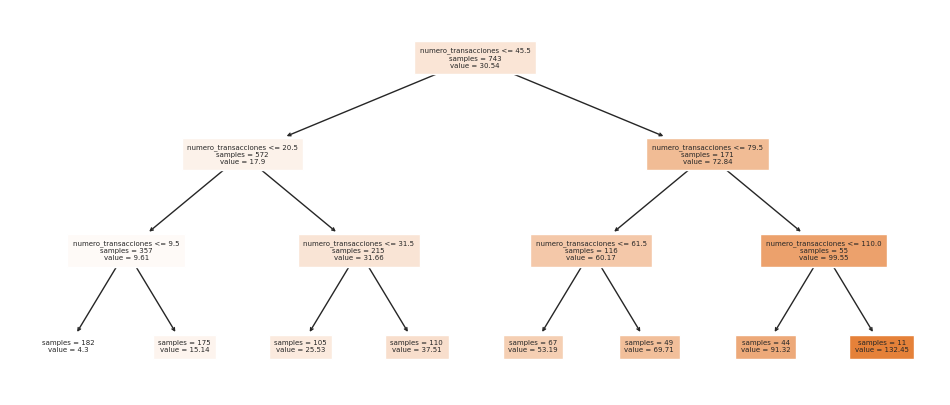

In [312]:
tree_plot(model_base, X.columns, data_categorica[1])

In [313]:
model_base.score(X, y, sample_weight=None)

0.9695913942718654

- **Alterando el número de columnas por cada división de cada región del árbol**
---

In [314]:
params_t = params_base_master.copy()
params_t['max_features'] = "sqrt"
model_base.set_params(
   **params_t
)
model_base.fit(X, y)
importances_feature(model_base, X.columns)

,predictor,importancia
2,numero_transacciones,0.85
3,numero_trimestres_activos,0.15
0,tipo_contraprestacion_COMPENSACIÓN,0.00
1,tipo_contraprestacion_REGALIAS,0.00
4,ano_produccion_activos,0.00


Profundidad del árbol: 3
Número de nodos terminales: 8


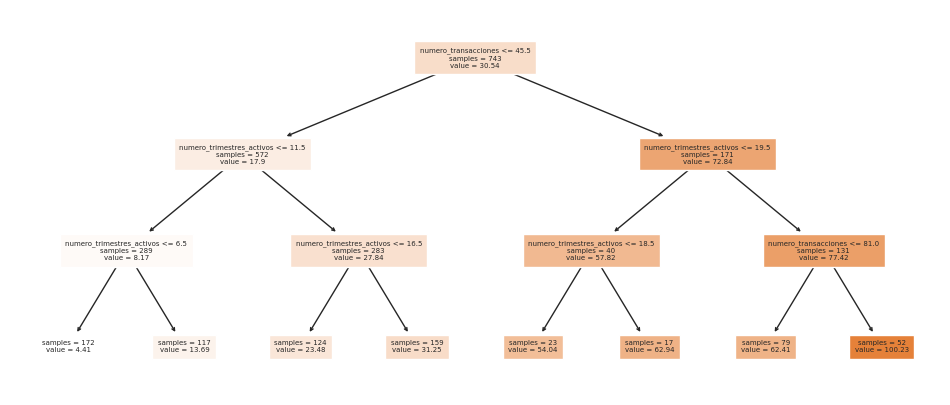

In [315]:
tree_plot(model_base, X.columns, data_categorica[1])

In [316]:
params_t = params_base_master.copy()
params_t['max_features'] = "log2"
model_base.set_params(
   **params_t
)
model_base.fit(X, y)
importances_feature(model_base, X.columns)

,predictor,importancia
2,numero_transacciones,0.85
3,numero_trimestres_activos,0.15
0,tipo_contraprestacion_COMPENSACIÓN,0.00
1,tipo_contraprestacion_REGALIAS,0.00
4,ano_produccion_activos,0.00


In [317]:
params_t = params_base_master.copy()
params_t['max_features'] = 1
model_base.set_params(
   **params_t
)
model_base.fit(X, y)
importances_feature(model_base, X.columns)

,predictor,importancia
2,numero_transacciones,0.49
4,ano_produccion_activos,0.47
1,tipo_contraprestacion_REGALIAS,0.02
3,numero_trimestres_activos,0.02
0,tipo_contraprestacion_COMPENSACIÓN,0.00


Profundidad del árbol: 3
Número de nodos terminales: 8


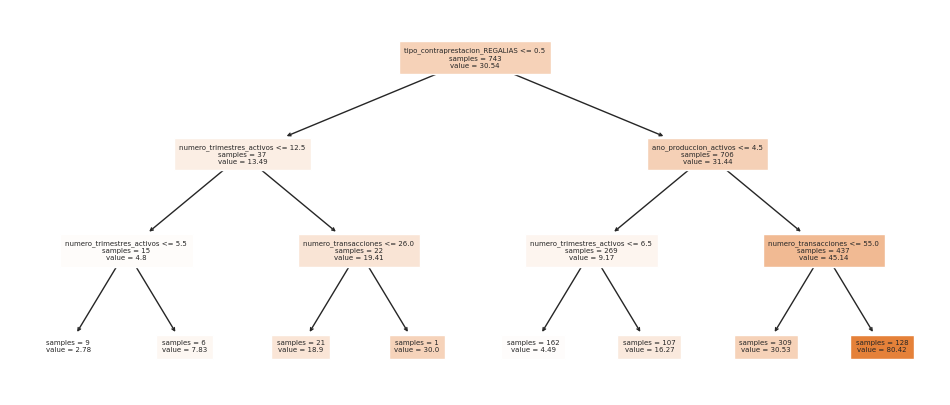

In [318]:
tree_plot(model_base, X.columns, data_categorica[1])

#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr